In [66]:
import numpy as np
import ggseg
import pickle

from matplotlib import pyplot as plt 
import pandas as pd 
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
import plotly.offline as pyo

import json

### LOAD FILE

In [67]:
read_input_file = open('data/Data.pickle','rb')
load_inputs = pickle.load(read_input_file)
read_input_file.close()

T, S, Sboot = load_inputs

In [68]:
subtype_labels = ['Subcortical subtype', 'Frontal subtype', 'Parietal subtype','Typical subtype']

# Separate Subcortical & Cortical Regions

### Load mappings

In [69]:
f = open('data/DK_2D_combined.json')
DK_2D_combined = json.load(f)
f.close()

f = open('data/ASEG_combined.json')
ASEG_2D_combined = json.load(f)
f.close()

### Map DK

Map values from larger regions to each small region included

In [70]:
def dk_dict(T,S, mapped_dict, subtype_labels = None, subtype = None):
    
    """
    Creates a dictionary, which can be used as input to ggseg.plot_dk() function
    :param T: dataframe from dk_dataframe() function
    :param S: chosen subtype
    :param mapped_dict: a dictionary with key: values --> T.biomarker_labels: list(DK-labels)
    :param subtype: name or index of the subtype from subtype_lables (optional, choses first available subtype as default)  
    :param subtype_labels: a list with names of the subtypes (optional)
    :return: dictionary with scores for each DK region for chosen subtype
    """
    
    unique_subtypes = np.unique(S['subtypes'][~np.isnan(S['subtypes'])])
    if subtype_labels is None:
        subtype_labels = {f'Subtype {i}': i for i in range(len(unique_subtypes))}
        if subtype is None:
            subtype = next(iter(subtype_labels))
    else:
        subtype_labels = {subtype_labels[i]: i for i in range(len(unique_subtypes))}
    
    if subtype is None:
        subtype = subtype_labels[0]  
               
    # clean names from capital letters
    labels = list(map(lambda x: x.lower(), T.biomarker_labels))
    labels_dict = {num: label.lower() for num, label in enumerate(labels)}
    
    # order the regions
    order = T.sequence_model['ordering'][subtype_labels[subtype]]   
    labels_ordered = []
    for o in order:
        labels_ordered.append(labels_dict[o])   
    
    # get event centers for all regions
    dic = dict(zip(labels_ordered, T.sequence_model['event_centers'][subtype_labels[subtype]]))
                    
    # flat list of dict values (single list of DK-labels)
    dk_flat = [x for v in mapped_dict.values() for x in v]
                
    #Match T.biomarker_labels to DK labels
    list_plot = list()
    for key in mapped_dict.keys():
            for item in mapped_dict[key]:
                list_plot.append(dic[key])
                    
    # Dict for dk-label: T.label value
    dic_dk = dict(zip(dk_flat, list_plot))
    
    return dic_dk

In [71]:
def aseg_dict(T, S, mapped_dict, subtype_labels = None, subtype = None, hemi = False):
    
    """
    Creates a dictionary, which can be used as input to ggseg.plot_dk() function
    :param T: Timeline object
    :param S: subtyping dictionary, subtypes for each patient individually
    :param mapped_dict: a dictionary with key: values --> T.biomarker_labels: list(DK-labels)
    :param subtype_labels: a list with names of the subtypes (optional)
    :param subtype: name or index of the subtype from subtype_lables (optional, choses first available subtype as default)  
    :return: dictionary with scores for each DK region for chosen subtype
    """

    unique_subtypes = np.unique(S['subtypes'][~np.isnan(S['subtypes'])])
    if subtype_labels is None:
        subtype_labels = {f'Subtype {i}': i for i in range(len(unique_subtypes))}
        if subtype is None:
            subtype = next(iter(subtype_labels))
    else:
        subtype_labels = {subtype_labels[i]: i for i in range(len(unique_subtypes))}
    
    if subtype is None:
        subtype = subtype_labels[0]  
    
    # clean names from capital letters
    labels = T.biomarker_labels
    labels_dict = {num: label.lower() for num, label in enumerate(labels)}
    order = T.sequence_model['ordering'][subtype_labels[subtype]]
    
    # order the regions
    labels_ordered = []
    for o in order:
        labels_ordered.append(labels_dict[o])    
     
    # Dictionary with all labels
    dic = dict(zip(labels_ordered, T.sequence_model['event_centers'][subtype_labels[subtype]]))
    
    # flat list of dict values (single list of DK-labels)
    aseg_flat = [x for v in mapped_dict.values() for x in v]
            
    #Match T.biomarker_labels to DK labels
    list_plot = list()
    for key in mapped_dict.keys():
        for item in mapped_dict[key]:
            list_plot.append(dic[key])
            
    # Dict for dk-label: T.label value
    dic_aseg = dict(zip(aseg_flat, list_plot))    
        
    return dic_aseg

### Combined function rerturning both plots

In [72]:
def plot_ggseg(T,S, map_dk, map_aseg, subtype_labels = None, subtype = None): 
    
    import ggseg
    """
    Creates a dictionary, which can be used as input to ggseg.plot_dk() function
    :param T: Timeline object
    :param S: subtyping dictionary, subtypes for each patient individually
    :param mapped_dict: a dictionary with key: values --> T.biomarker_labels: list(DK-labels)
    :param subtype_labels: a list with names of the subtypes (optional)
    :param subtype: name or index of the subtype from subtype_lables (optional, choses first available subtype as default)  
    :return: two plots -> ggseg.plot_dk() and ggseg.plot_aseg()
    """
    
    dk = dk_dict(T, S, mapped_dict = map_dk, subtype = subtype, subtype_labels=subtype_labels)   
    aseg = aseg_dict(T,S, mapped_dict = map_aseg, subtype = subtype,subtype_labels=subtype_labels)
    
    if subtype is None:
        subtype = 'default = 0'

    
    ggseg.plot_dk(dk, cmap='Reds_r', figsize=(10,10),
              vminmax = [0,1],
              background='k', edgecolor='w', bordercolor='gray', title=f'{subtype}',
                fontsize = 24)

    ggseg.plot_aseg(aseg, cmap='Reds_r', figsize=(10,10),
                vminmax = [0,1],
                background='k', edgecolor='w', bordercolor='gray', title=f'{subtype}',
                fontsize = 24)

## Separate plots - for Streamlit App, with Slider

In [73]:
def plot_dk_atlas(T,S, map_dk, subtype_labels = None, subtype = None, slider = None):     

    """
    Creates a dictionary, which can be used as input to ggseg.plot_dk() and plots it
    :param T: Timeline object
    :param S: subtyping dictionary, subtypes for each patient individually
    :param subtype_labels: a list with names of the subtypes (optional)
    :param subtype: name or index of the subtype to visualise (optional)  
    :param slider: int (optional)
    :returns a figures by plt.show() -> ggseg.plot_dk() 
    """   
    
    if slider is None:
        dk = dk_dict(T, S, mapped_dict = map_dk, subtype = subtype,subtype_labels=subtype_labels)  
    else:
        dk_ = dk_dict(T, S, mapped_dict = map_dk, subtype = subtype,subtype_labels=subtype_labels)
        dk = {k: v for k, v in dk_.items() if v <= slider}
        
    
    if subtype is None:
        pass
    else:
        return ggseg.plot_dk(dk, cmap='Reds_r', figsize=(6,6),
                  vminmax = [0,1],
                  background='black', edgecolor='white', bordercolor='gray', title=f'{subtype}',fontsize = 24)


def plot_aseg_atlas(T,S, map_aseg, subtype_labels = None, subtype = None, slider = None):     

    """
    Creates a dictionary, which can be used as input to ggseg.plot_aseg() function
    :param T: Timeline object
    :param S: subtyping dictionary, subtypes for each patient individually
    :param subtype_labels: a list with names of the subtypes (optional)
    :param subtype: name or index of the subtype to visualise (optional)  
    :param slider: int (optional)
    :returns a figures by plt.show() -> ggseg.plot_aseg()
    """
    if slider is None:  
        aseg = aseg_dict(T,S, map_aseg,subtype = subtype,subtype_labels=subtype_labels)
    else:
        aseg_ = aseg_dict(T,S, map_aseg, subtype = subtype,subtype_labels=subtype_labels)
        aseg = {k: v for k, v in aseg_.items() if v <= slider}

    if subtype is None:
        pass 
    else:
        return ggseg.plot_aseg(aseg, cmap='Reds_r', figsize=(6,6),
                vminmax = [0,1],
                background='black', edgecolor='white', bordercolor='gray', title=f'{subtype}', fontsize = 18)

## Examples

In [74]:
# 1. Map to DK-labels
dk_0_new = dk_dict(T, S, mapped_dict = DK_2D_combined, 
                   subtype='Subcortical subtype',
                  subtype_labels = subtype_labels
                  )
# dk_0_new

In [75]:
# 2. Map to ASEG-labels
aseg_0_new = aseg_dict(T,S, mapped_dict = ASEG_2D_combined,
                      subtype='Subcortical subtype',
                      subtype_labels = subtype_labels
                      )
aseg_0_new

{'Right-Thalamus': 0.2828902112598796,
 'Left-Thalamus': 0.2828902112598796,
 'Right-Caudate': 0.016190040180560587,
 'Left-Caudate': 0.016190040180560587,
 'Right-Putamen': 0.13888024926558973,
 'Left-Putamen': 0.13888024926558973,
 'Right-Hippocampus': 0.3697820092059501,
 'Left-Hippocampus': 0.3697820092059501,
 'Right-Amygdala': 0.3464400738843289,
 'Left-Amygdala': 0.3464400738843289}

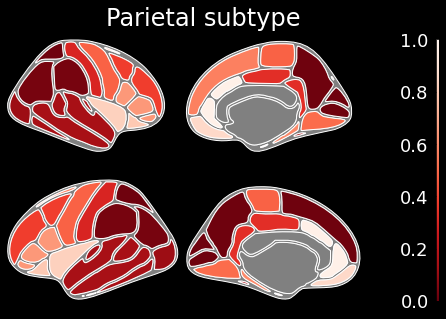

In [76]:
# 3. Plot DK
plot_dk_atlas(T = T, S = S, map_dk = DK_2D_combined,
             subtype='Parietal subtype',
            subtype_labels = subtype_labels)  

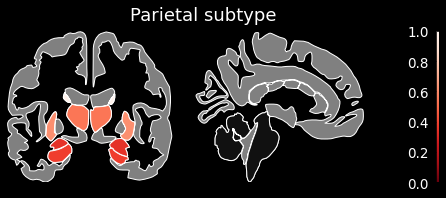

In [77]:
# 4. Plot ASEG
plot_aseg_atlas(T = T, S = S, map_aseg = ASEG_2D_combined,
               subtype='Parietal subtype',
            subtype_labels = subtype_labels)  

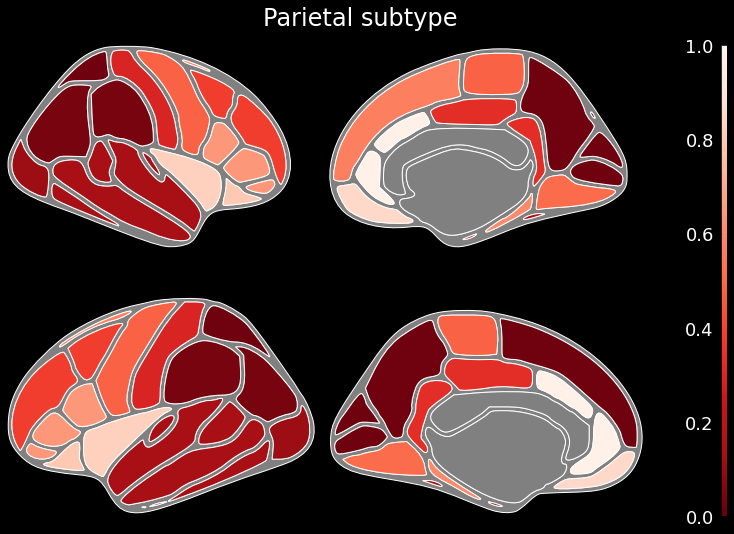

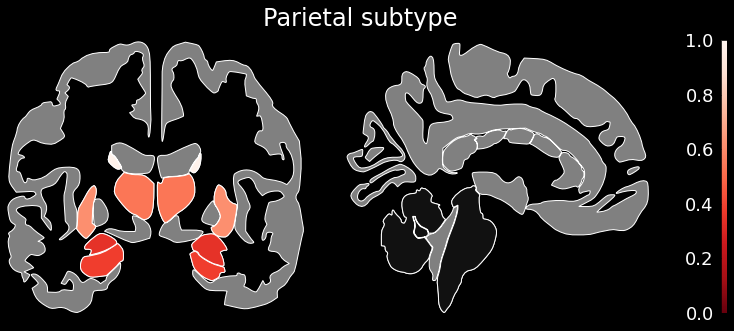

In [78]:
# 5. Plot together
plot_ggseg(T, S, DK_2D_combined, ASEG_2D_combined, 
           subtype_labels = subtype_labels, 
           subtype = 'Parietal subtype')